In [5]:
import prop
import pandas as pd
import matplotlib.pyplot as plt
from modules import pump, regen, heater, turbine, condenser

#Таблица с потоками и блоками:
streams = pd.read_excel("streams.xlsx",index_col=0)
blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)

#Параметры нагревающей среды:
gas  = 'REFPROP::N2[0.7757]&O2[0.1568]&CO2[0.0193]&H2O[0.04]&Ar[0.0082]' #Состав газа!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Tin  = 183.6                                                               #Температура газов на входе
Pgas = 0.1                                                                 #Давление газов
Ggas = 509                                                                 #Расход газов
Tout = 80                                                                  #Температура газов на выходе

#Параметры охлаждающей среды:
fluidcond  = "REFPROP::WATER" #Охлаждающая среда
Tfluidcond = 15               #Температура охл. среды
Pfluidcond = 0.5              #Давление охл. среды

#Параметры ОЦР:
fluid   = "REFPROP::R236ea"   #Рабочая среда цикла
Ppump   = 3.5                 #Давление на выходе из насоса
KPDpump = 0.8                 #КПД насоса
KPDturb = 0.9                 #КПД турбины
DTheat  = 20                  #Минимальный напор в нагревателе
DTcond  = 5                   #Минимальный напор в конденсаторе
Pcond   = prop.t_q(30,0,fluid)['P']               #Давление в конденсаторе

#Первое приближение


dTreg   = 8                   #Минимальный напор в регенераторе
dPreg1  = 0.02                #Потери по горячему в МПа
dPreg2  = 0.02                 #Потери по холодному

for j in range(100):
    streams = pd.read_excel("streams.xlsx",index_col=0)
    blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)

    
    #Внесение входных данных в таблицу:
    streams.loc["IN-HEAT", "T":"Q"] = [Tin,Pgas,prop.t_p(Tin,Pgas,gas)["H"],prop.t_p(Tin,Pgas,gas)["S"],Ggas,1]
    streams.loc["IN-COND", "T":"Q"] = [Tfluidcond,Pfluidcond,prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["H"],prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["S"],1000,0]

    #Начало расчёта - задание расхода на первой итерации:
    G = Ggas*(prop.t_p(Tin,Pgas,gas)["H"]-prop.t_p(Tout,Pgas,gas)["H"])/(prop.t_p(Tin,Ppump,fluid)["H"]-prop.t_p(Tout,Ppump,fluid)["H"])

    #Поток перед насосом:
    streams.loc["COND-PUMP", "T":"Q"] = [prop.p_q(Pcond,0,fluid)["T"],Pcond,prop.p_q(Pcond,0,fluid)['H'],prop.p_q(Pcond,0,fluid)['S'],G,0]

    #Итеративный расчет для сведения баланса:
    for i in range(100):
        #Расчет цикла:
        pump.calc     ("COND-PUMP", "PUMP-REG",                          Ppump,  KPDpump,     fluid, streams, blocks)
        regen.calc    ("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",  dTreg, dPreg1,dPreg2,fluid, streams, blocks)
        heater.calc   ("IN-HEAT",   "HEAT-OUT",  "REG-HEAT","HEAT-TURB", Tout,   DTheat, gas, fluid, streams, blocks)
        turbine.calc  ("HEAT-TURB", "TURB-REG",                          Pcond+dPreg1,  KPDturb,fluid, streams, blocks)
        regen.calc    ("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",  dTreg, dPreg1,dPreg2,fluid, streams, blocks)
        condenser.calc("REG-COND",  "COND-PUMP", "IN-COND" ,"COND-OUT",  DTcond, fluidcond,   fluid, streams, blocks)
        Qbalance = blocks.loc['HEATER','Q']+blocks.loc['PUMP','N']-blocks.loc['CONDENSER','Q']-blocks.loc['TURBINE','N']
        print (Qbalance)
        if abs(Qbalance) < 1: #Макс погрешность 1 кВт
            break


    REGEN = regen.constr("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",dPreg1,dPreg2,streams,blocks)
    KPD = (blocks.loc['TURBINE','N']-blocks.loc['PUMP','N'])/blocks.loc['HEATER','Q']
    
    dPreg1  = REGEN['dP1']
    dPreg2  = REGEN['dP2']
    if j != 0:
        if abs(dPreg1-dP1last)/dPreg1 < 0.1: #Макс расхождение потерь 10%
            break
    dP1last = dPreg1
print (dTreg, round(REGEN['dP1'],5), round(REGEN['dP2'],5), round(KPD,5), REGEN['money'])
    

3770.6770086231445
-1823.0389817365303
880.4954325216531
-441.50775191193134
230.64790528756384
-122.9576142180158
64.92527535255067
-34.46031489889356
18.239960402061115
-9.670884128427133
5.122432722531812
-2.711993896717104
1.4390615516585967
-0.766512769723704
3843.178114604776
-1910.9032703831763
957.0015299639908
-519.7961074649593
271.940380401702
-145.35971456975858
76.82303590785341
-40.84563669249292
21.651412809093017
-11.49706056708601
6.097270917698552
-3.23362069590803
1.7133927942013543
-0.907804233385832
8 0.02019 0.05083 0.16039 1838592


In [2]:
streams

,T,P,H,S,G,Q
IN-HEAT,183.600000,0.100000,527.439378,7.266439,509.000000,1.0
HEAT-OUT,80.000000,0.100000,419.639057,6.998847,509.000000,1.0
COND-PUMP,30.000000,0.244324,237.395788,1.129466,269.396106,0.0
PUMP-REG,31.711578,3.500000,240.271485,1.131354,269.383650,0.0
REG-HEAT,34.135075,3.493289,243.318164,1.141323,269.383650,0.0
HEAT-TURB,143.275523,3.493289,446.999410,1.688211,269.396106,1.0
TURB-REG,54.362706,0.263884,412.389369,1.700027,269.396106,1.0
REG-COND,50.711578,0.244324,409.342830,1.694616,269.396106,1.0
IN-COND,15.000000,0.500000,63.458441,0.224388,1000.000000,0.0
COND-OUT,26.074427,0.500000,109.780304,0.382133,1000.000000,0.0


In [3]:
blocks

,N,Q,COST
PUMP,774.665579,NaN,NaN
TURBINE,9323.810326,NaN,NaN
REGENERATOR,NaN,820.725629,NaN
CONDENSER,NaN,46321.863525,NaN
HEATER,NaN,54870.363600,NaN


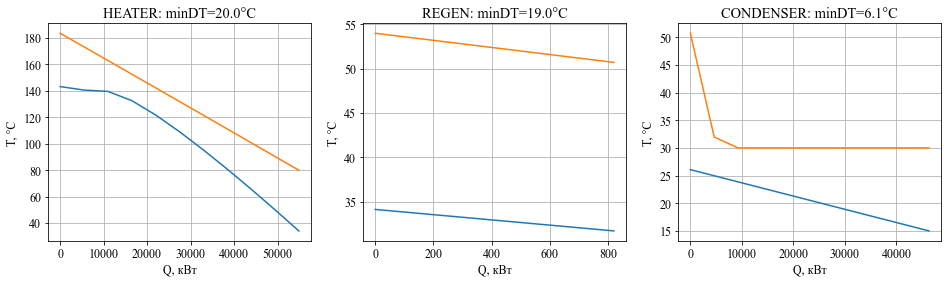

In [4]:
#Вывод T-Q:
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
heater.TQ("IN-HEAT","HEAT-OUT","REG-HEAT","HEAT-TURB",gas,fluid,streams)
plt.subplot(1, 3, 2)
regen.TQ("TURB-REG","REG-COND","PUMP-REG","REG-HEAT",fluid,streams)
plt.subplot(1, 3, 3)
condenser.TQ("REG-COND","COND-PUMP","IN-COND","COND-OUT",fluidcond,fluid,streams)
plt.show()